In [1]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Importing Training Data


In [2]:
#reading data into keras data loader or whatever they use
dataset_path = "/kaggle/input/chili-images-for-classification/training_images"

#num_classes = 4
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3868 files belonging to 4 classes.


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3868 files belonging to 4 classes.
Using 3095 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3868 files belonging to 4 classes.
Using 773 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Charapita', 'Limeno', 'Limo', 'Rocoto']


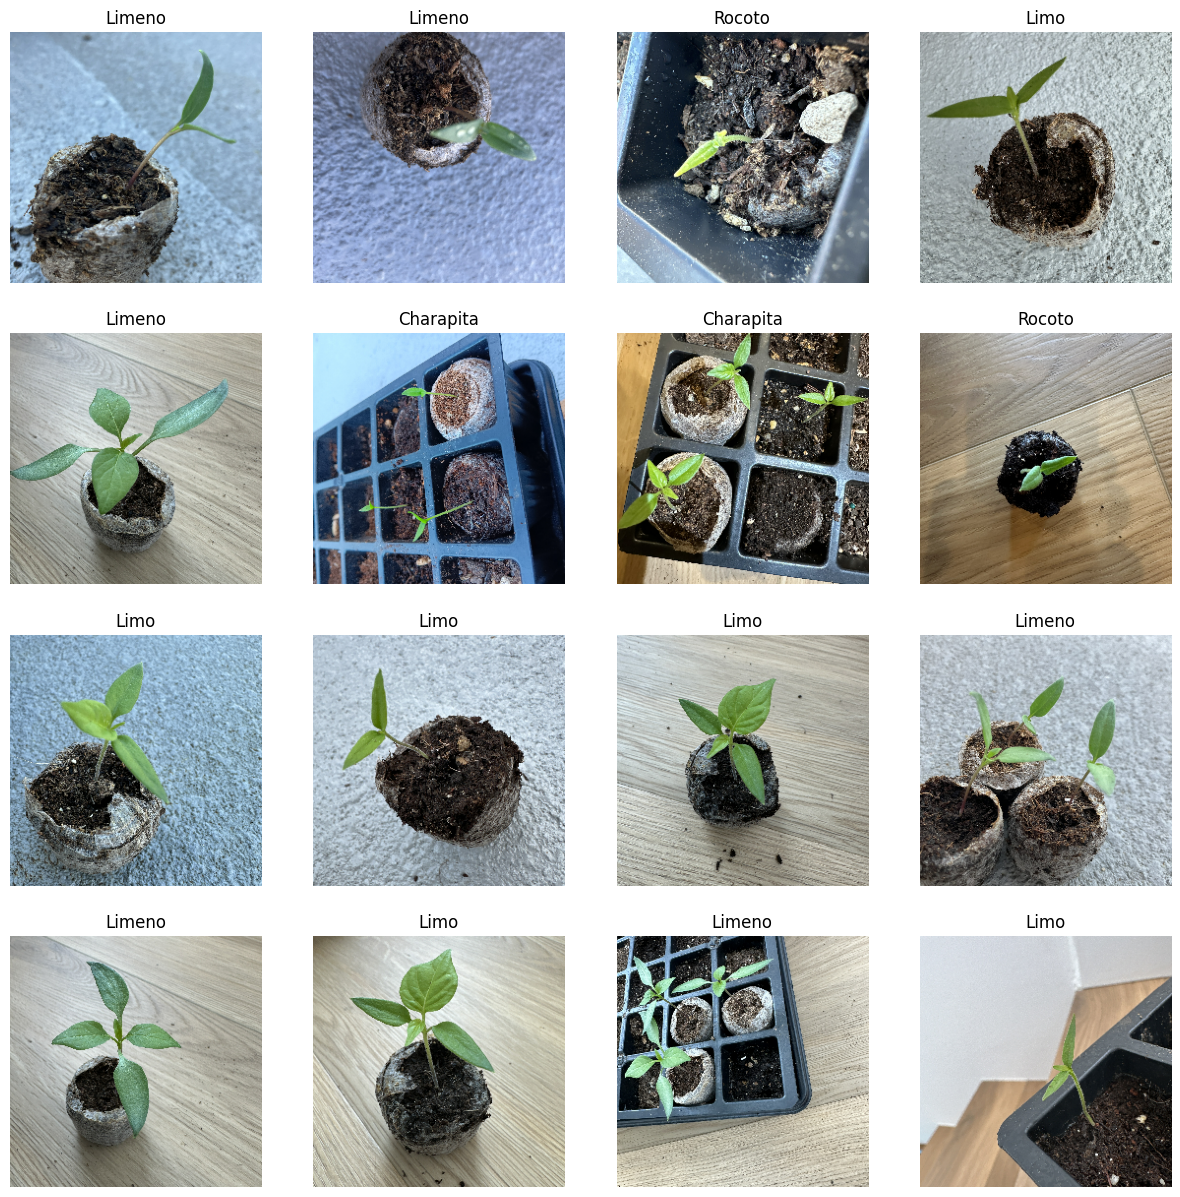

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# Normalizing data
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [9]:
# Improving performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
from keras import layers
from tensorflow.keras.layers import RandomWidth

# Data augmentation 
data_augmentation = keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    layers.RandomContrast(factor=0.5),
    layers.RandomFlip(mode='horizontal'), # meaning, left-to-right
    layers.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    tf.keras.layers.RandomWidth(factor=0.30), # horizontal stretch
    layers.RandomRotation(factor=0.05),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

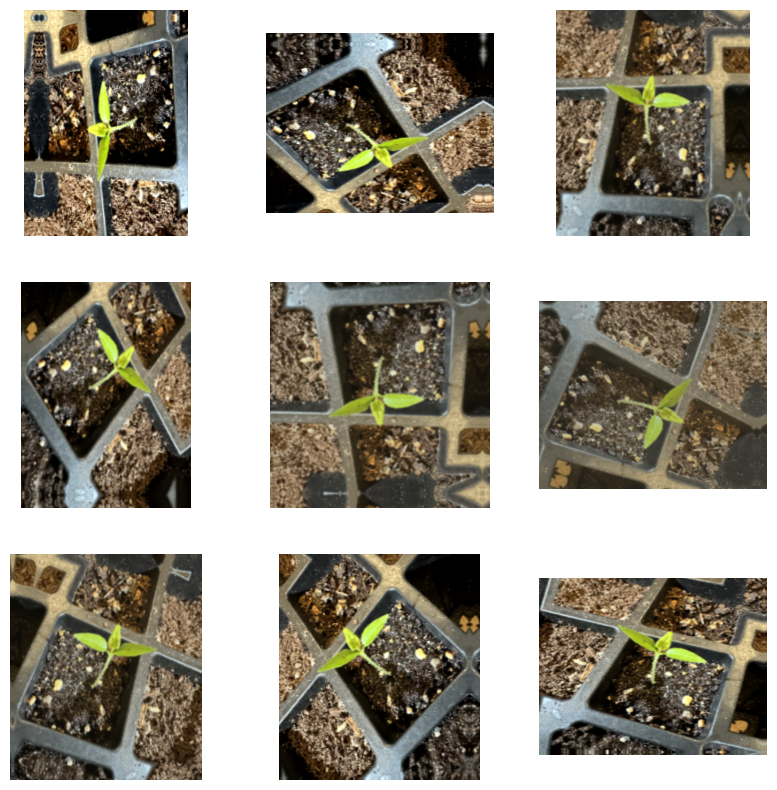

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# 2. Designing a Convolutional Neural Network with transfer learning
#### The pretrained base will be Resnet50V2

In [12]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

pretained_base = keras.applications.resnet_v2.ResNet50V2()
# include_top=False

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
''' num_classes = 4

pepper_model = keras.Sequential([
    keras.layers.InputLayer(shape=[256,256,3]), 
    
#     keras.layers.InputLayer(
#     shape= [256,256,3]),
   
    # Data Augmentation
    layers.RandomContrast(factor=0.5),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomFlip(mode='vertical'),
    tf.keras.layers.RandomWidth(factor=0.30),
    layers.RandomRotation(factor=0.05),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
#     layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Global pooling before flattening
#     layers.GlobalAveragePooling2D(),

    # Head
#     layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

# Set the first layer to non-trainable
pepper_model.layers[0].trainable = False

pepper_model.summary() '''

" num_classes = 4\n\npepper_model = keras.Sequential([\n    keras.layers.InputLayer(shape=[256,256,3]), \n    \n#     keras.layers.InputLayer(\n#     shape= [256,256,3]),\n   \n    # Data Augmentation\n    layers.RandomContrast(factor=0.5),\n    layers.RandomFlip(mode='horizontal'),\n    layers.RandomFlip(mode='vertical'),\n    tf.keras.layers.RandomWidth(factor=0.30),\n    layers.RandomRotation(factor=0.05),\n    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),\n\n    # Block One\n    layers.BatchNormalization(),\n    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),\n    layers.MaxPool2D(),\n\n    # Block Two\n    layers.BatchNormalization(),\n    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),\n    layers.MaxPool2D(),\n\n    # Block Three\n    layers.BatchNormalization(),\n    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),\n#     layers.Conv2D(filters=256, kernel_size=3, activation=

In [14]:
pepper_model = keras.Sequential([ 
    keras.layers.InputLayer(shape=[256,256,3]),

    # Data Augmentation
    tf.keras.layers.RandomContrast(factor=0.5),
#     tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomFlip(mode='vertical'),
#     tf.keras.layers.RandomWidth(factor=0.30),
#     tf.keras.layers.RandomRotation(factor=0.05),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.05),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.05),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.05),

    # Global pooling before flattening
    layers.GlobalAveragePooling2D(),

    # Head
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='softmax'),  # 4 classes for multiclass classification
])

# Set the first layer to non-trainable
pepper_model.layers[0].trainable = False

pepper_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 256, 256, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,688 (1.43 MB)

 Trainable params: 373,298 (1.42 MB)

 Non-trainable params: 390 (1.52 KB)

In [15]:
# Compile the model
pepper_model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
# pepper_model.fit(
#         train_ds,
#         validation_data=val_ds,
# epochs=50)

In [17]:
#implementing early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         patience=10,
                                        restore_best_weights=True)

In [18]:
# Fit the model
history = pepper_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=[callback]
)

Epoch 1/80


2024-09-23 02:56:20.325128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.4652 - loss: 1.1162 - val_accuracy: 0.5433 - val_loss: 1.1184
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.6299 - loss: 0.8641 - val_accuracy: 0.4010 - val_loss: 1.1981
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.6777 - loss: 0.7416 - val_accuracy: 0.3441 - val_loss: 1.4501
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.7142 - loss: 0.6866 - val_accuracy: 0.7063 - val_loss: 0.8034
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.7368 - loss: 0.6466 - val_accuracy: 0.7788 - val_loss: 0.6517
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.7340 - loss: 0.6467 - val_accuracy: 0.6404 - val_loss: 0.7976
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.7620 - loss: 0.5855 - val_accuracy: 0.6934 - val_loss: 0.6509
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.7741 - loss: 0.5787 - val_accuracy: 0.7995 

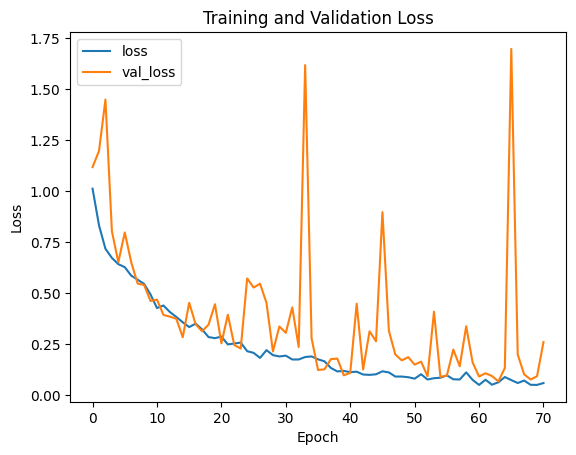

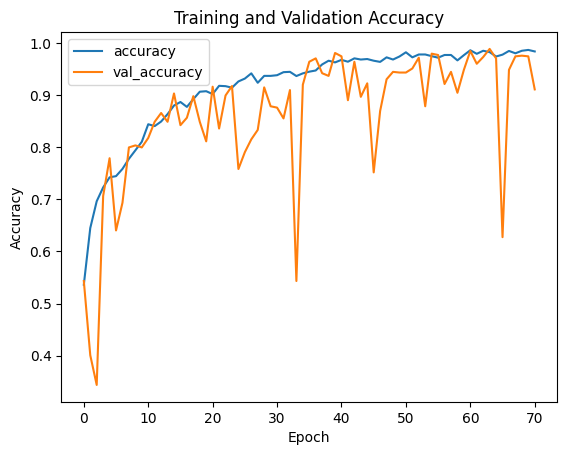

In [19]:
# Convert history to DataFrame for easier plotting
history_frame = pd.DataFrame(history.history)

# Plot loss and validation loss
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot accuracy and validation accuracy
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [20]:
pepper_model.save('pepper_model_9_20.h5')
